In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d rajneeshbansal/salt-and-pepper-noise-dataset/data

403 - Forbidden - Permission 'datasets.get' was denied


In [4]:
!pip install opendatasets

In [5]:
!pip install split-folders

In [6]:
import opendatasets as od
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, UpSampling2D, BatchNormalization, Input, Reshape
from keras.callbacks import EarlyStopping

In [7]:
od.download('https://www.kaggle.com/datasets/rajneesh231/salt-and-pepper-noise-images/data')

Skipping, found downloaded files in "./salt-and-pepper-noise-images" (use force=True to force download)


In [8]:
splitfolders.ratio('/content/salt-and-pepper-noise-images', output='/content/output', seed = 1333, ratio=(0.9,0.1))

Copying files: 600 files [00:00, 2995.44 files/s]


In [9]:
# rescaling pixel values
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [10]:
# creating traning data generator
train_generator = train_datagen.flow_from_directory(
    '/content/output/train',
    target_size = (200, 200),
    batch_size = 47163,
    class_mode = 'input'
)

Found 540 images belonging to 2 classes.


In [11]:
# creating testing data generator
test_generator = test_datagen.flow_from_directory(
    '/content/output/val',
    target_size = (200, 200),
    batch_size = 11791,
    class_mode = 'input'
)

Found 60 images belonging to 2 classes.


In [12]:
x_train, y_train = next(train_generator)
x_test, y_test = next(test_generator)

In [13]:
# adding noise to x_train and x_test to simulate noisy data
noise_factor = 0.2
x_train_rand = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_rand = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

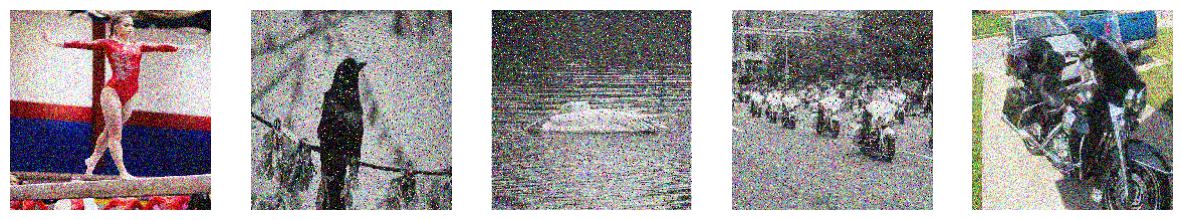

In [14]:
f, axs = plt.subplots(1, 5, figsize=(15, 8))
for j in range(len(axs)):
  axs[j].imshow(x_train_rand[j+5], cmap='gray')
  axs[j].axis('off')

In [15]:
# encoder architecture
encoder_noise = Sequential([

    Conv2D(input_shape = (200,200,3), filters = 256, kernel_size = (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same')
])

encoder_noise.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 128)       │         295,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,208 (1.15 MB)

 Trainable params: 302,208 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
decoder_noise = Sequential ([
    Conv2D(input_shape=(100, 100, 128), filters = 128, kernel_size=(3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

decoder_noise.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 200, 200, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 200, 200, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 200, 200, 3)         │           6,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 449,667 (1.72 MB)

 Trainable params: 449,667 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# building auto-encoder
autoencoder_noise = Model(inputs = encoder_noise.inputs, outputs = decoder_noise(encoder_noise.outputs))

# define earlystopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# compiling the model
autoencoder_noise.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# traning the model
history = autoencoder_noise.fit(x_train_rand, x_train, epochs=50, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5001 - loss: 0.6530 - val_accuracy: 0.5923 - val_loss: 0.5792
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5415 - loss: 0.5710 - val_accuracy: 0.7028 - val_loss: 0.5597
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6720 - loss: 0.5550 - val_accuracy: 0.5668 - val_loss: 0.5482
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4653 - loss: 0.5444 - val_accuracy: 0.6678 - val_loss: 0.5410
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5449 - loss: 0.5383 - val_accuracy: 0.4042 - val_loss: 0.5373
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4913 - loss: 0.5363 - val_accuracy: 0.4397 - val_loss: 0.5364
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4876 - loss: 0.5342 - val_accuracy: 0.5521 - val_loss: 0.5361
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4724 - loss: 0.5332 - val_accuracy: 0.5022 - va

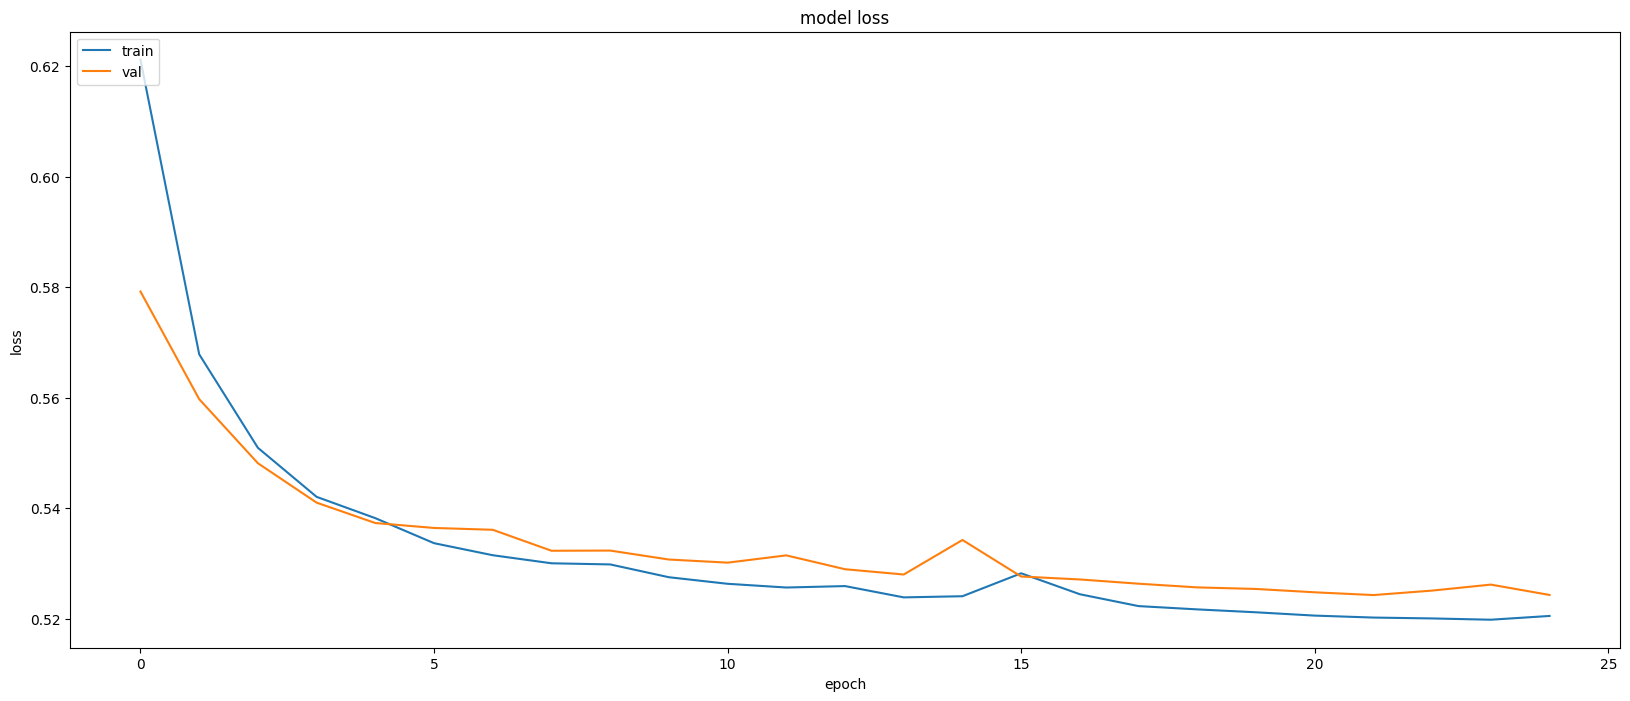

In [19]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
x_predict = history.model.predict(x_test_rand)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


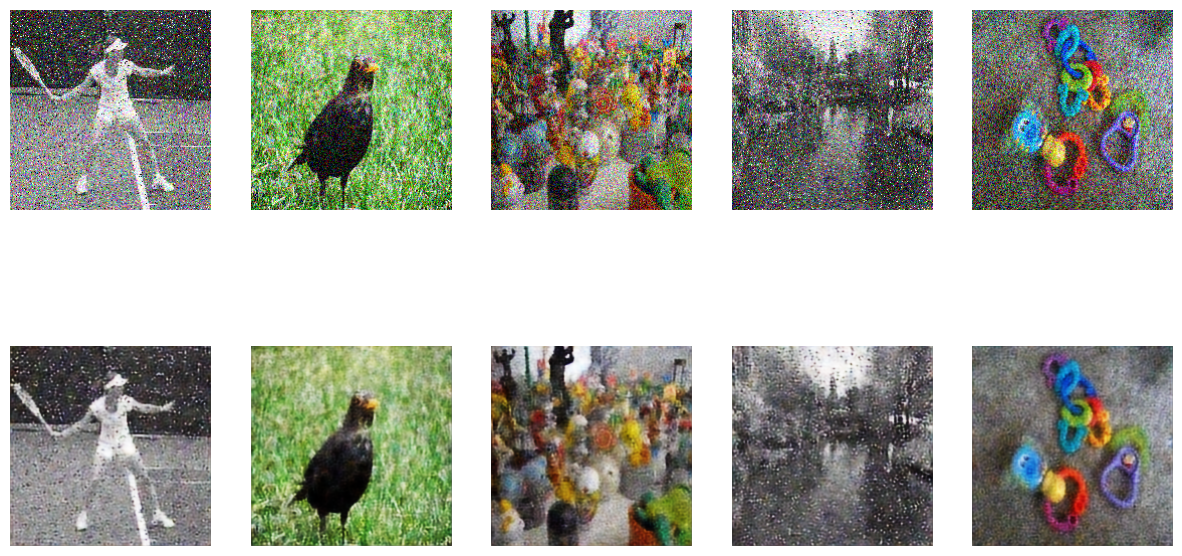

In [21]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
for j in range(5):
    axs[0, j].imshow(x_test_rand[j+13], cmap='binary')
    axs[1, j].imshow(x_predict[j+13], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')